In [1]:
# show plots in notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# Plots

In [189]:
def plot3d(xs, ys, zs, title="Lorenz Attractor"):
    # Plot
    fig = plt.figure(figsize=(18,8))
    ax1 = fig.add_subplot(3,2,1)
    ax2 = fig.add_subplot(3,2,3)
    ax3 = fig.add_subplot(3,2,5)
    ax1.set_ylabel('Xs')
    ax2.set_ylabel('Ys')
    ax3.set_ylabel('Zs')
    ax1.plot(xs)
    ax2.plot(ys)
    ax3.plot(zs)
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot(xs, ys, zs, lw=0.2)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title(title)
    plt.show()

# Takens

In [186]:
def create_lagged_series(time_series, num_series=10, lag_step=100):
    """
    Conceito de Takens Embedding Theorem
    :param []     time_series : uma serie temporal
    :param number lag_size    : tamanho do atraso, também conhecido como tau
    :param number num_series  : número de séries a serem criadas, sendo o indice Zero a serie original
    :returns: Lista de series com atrasos
    """
    series = []
    tail_size = (num_series-1) * lag_step
    for i in range(num_series):
        s = np.roll(time_series, -i*lag_step)
        series.append(s[:-tail_size])
    return series

# Lorenz

In [160]:
def generate(data_length, odes, state, parameters):
    data = np.zeros([state.shape[0], data_length])
    for i in range(5000):
        state = rk4(odes, state, parameters)

    for i in range(data_length):
        state = rk4(odes, state, parameters)
        data[:, i] = state
    return data

def rk4(odes, state, parameters, dt=0.01):
    k1 = dt * odes(state, parameters)
    k2 = dt * odes(state + 0.5 * k1, parameters)
    k3 = dt * odes(state + 0.5 * k2, parameters)
    k4 = dt * odes(state + k3, parameters)
    return state + (k1 + 2 * k2 + 2 * k3 + k4) / 6

def lorenz_odes(state, parameters):
    x,y,z=state
    sigma, beta, rho=parameters
    return np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])

def lorenz_generate(data_length):
    return generate(data_length, lorenz_odes, 
                    np.array([-8.0, 8.0, 27.0]), 
                    np.array([10.0, 8/3.0, 28.0]))

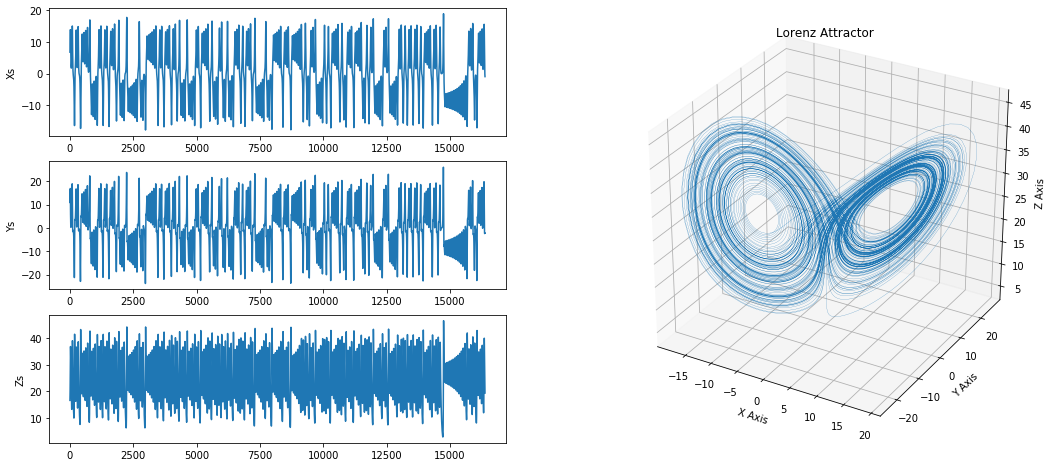

In [177]:
xs, ys, zs = lorenz_generate(2**14)
plot3d(xs, ys, zs, title="Lorenz Attractor")

## Reconstrução do Atrator utilizando somente 1 dimensão de Lorenz

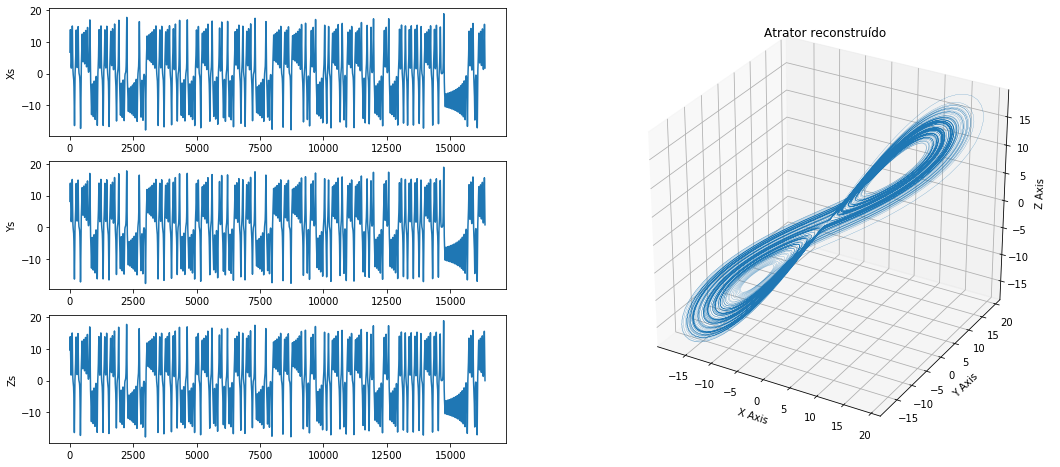

In [187]:
# Utilizando somente uma dimensão do atrator de Lorenz
xs, ys, zs = create_lagged_series(xs, num_series=3, lag_step= 3)
plot3d(xs, ys, zs, title="Atrator reconstruído")

# Preparação dos dados para análise

Dados correspondentes a *Golden (USD)*

In [179]:
df = pd.read_csv('./data/WGC-GOLD_DAILY_USD.csv')
serie = df.Value.values.tolist()[::-1]
indexes = list(range(len(serie)))

# Combinação dos dados
Após a união de dados financeiros de ouro e bitcoin, utilizando a data como critério de união, podemos considerar que teremos os mesmos momentos históricos para análise de séries temporais.

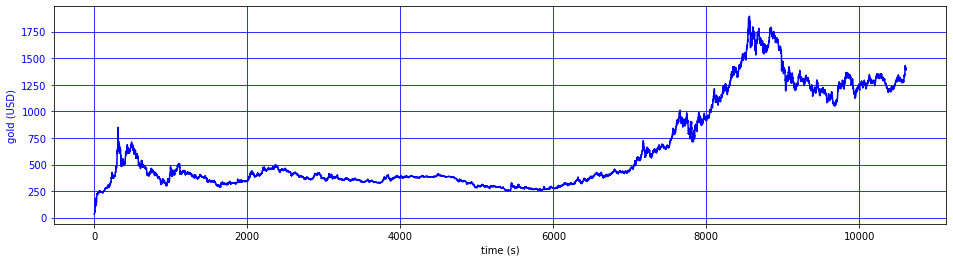

In [182]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(indexes, serie, 'b-')
ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('gold (USD)', color='b')
ax1.tick_params('y', colors='b')
ax1.grid(color='b')

# ax2 = ax1.twinx()
# ax2.plot(df.index, df['bitcoin'], 'r-')
# ax2.set_ylabel('bitcoin (USD)', color='r')
# ax2.tick_params('y', colors='r')
# ax2.grid(color='r')
# fig.tight_layout()
# plt.title('Gold vs Bitcoin price')
plt.show()

In [191]:
def heaviside_step(v):
    return 1 if v > 0 else 0

def norm(a,b):
    s = np.array(a)- np.array(b)
    s = np.power(a,2)
    s = np.sum(s)
    return np.sqrt(s)

def correlation(series, r,n):
    s=len(series)
    somatorio=0
    for i in range(n):
        for j in range(n):
            ti=[series[k][i] for k in range(s)]
            tj=[series[k][j] for k in range(s)]
            somatorio += heaviside_step(r-norm(ti,tj))
    c=(2/float((n*(n-1))))+somatorio
    return c

In [192]:
def is_like(a,b,limiar=0.5):
    k=abs(a-b)
    print("k",k)
    print("limiar",limiar)
    return k<=abs(limiar)

def find_saturation(m_list,v_list):
    v_list_len=len(v_list)
    m_list_len=len(m_list)
    
    if v_list_len != m_list_len: raise ValueError("listas de tamanhos diferentes")
    if v_list_len < 2: raise ValueError("lista menor menor que 2 ")
    
    print("m_list",m_list)
    print("v_list",v_list)
    m=None
    v_old=v_list[0]
    for i,v in enumerate(v_list[1:]):
        if is_like(v,v_old,v/100.0):
            m=m_list[max(0,i-1)]
            
            break
        v_old=v_list[i]
    return m

In [193]:
def calc_attractor_dimension(serie,dim_min=1,dim_max=20):
    """
    Baseado no Grassberger-Procaccia Algorithm
    :param serie: uma serie temporal
    :returns: um float com a dimensão encontrada. Ou "-1" caso não encontre 
    """
    m=dim_min
    limiar=0.5
    alpha=1
    tau=1
    is_attractor=False
    n=10
    v_list=[]
    m_list=list(range(1,dim_max+1))
    r=np.std(serie[:n])
    print("r",r)
    for m in m_list:
        lagged_series = create_lag_series(serie, num_series=m, lag_step=tau)
        c = correlation(lagged_series, r, n)
        v_list.append(np.log10(c)/np.log10(r))
    return find_saturation(m_list,v_list) 

In [194]:
calc_attractor_dimension(serie,dim_min=2,dim_max=20)

r 4.11738994995616


IndexError: index 0 is out of bounds for axis 0 with size 0

In [158]:
lagged_series[0]

array([], dtype=float64)

In [135]:
lagged_series=create_lag_series(serie, num_series=1, lag_step=1)

In [90]:
r=np.std(serie[:10])
r

4.11738994995616

In [ ]:
c=correlation(lagged_series, r,10)

In [121]:
dt = 0.01
num_steps = 10000
xs, ys, zs = create_time_series_lorenz(dt, num_steps, s=10, r=28, b=2.667)

In [123]:
serie = df['gold'].tolist()
serie = serie[:num_steps]
lag_step = 100
num_series = 10
series = create_lag_series(serie, num_series=num_series, lag_step=lag_step)
series = np.array(series)

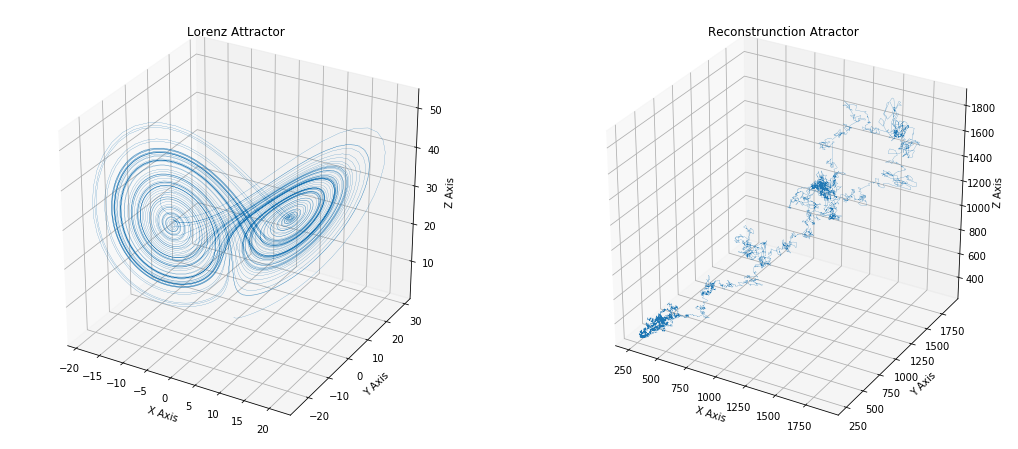

In [124]:
# Plot
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.plot(xs, ys, zs, lw=0.2)
ax1.set_xlabel("X Axis")
ax1.set_ylabel("Y Axis")
ax1.set_zlabel("Z Axis")
ax1.set_title("Lorenz Attractor")

ax2.plot(series[0], series[1], series[2], lw=0.2)
ax2.set_xlabel("X Axis")
ax2.set_ylabel("Y Axis")
ax2.set_zlabel("Z Axis")
ax2.set_title("Reconstrunction Atractor")
plt.show()

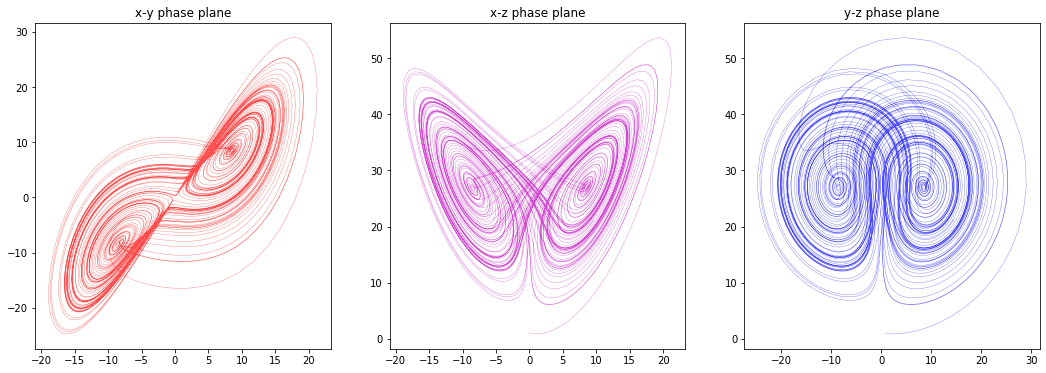

In [125]:
# now plot two-dimensional cuts of the three-dimensional phase space
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

# plot the x values vs the y values
ax1.plot(xs, ys, color='r', alpha=0.7, linewidth=0.3)
ax1.set_title('x-y phase plane')

# plot the x values vs the z values
ax2.plot(xs, zs, color='m', alpha=0.7, linewidth=0.3)
ax2.set_title('x-z phase plane')

# plot the y values vs the z values
ax3.plot(ys, zs, color='b', alpha=0.7, linewidth=0.3)
ax3.set_title('y-z phase plane')

#fig.savefig('{}/lorenz-attractor-phase-plane.png'.format('images'), dpi=180, bbox_inches='tight')
plt.show()

In [126]:
xs, ys, zs = series[0], series[1], series[2]

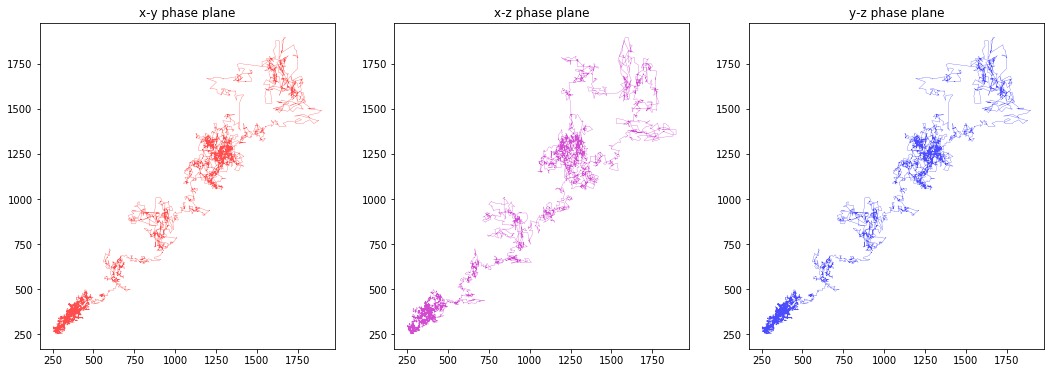

In [127]:
# now plot two-dimensional cuts of the three-dimensional phase space
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

# plot the x values vs the y values
ax1.plot(xs, ys, color='r', alpha=0.7, linewidth=0.3)
ax1.set_title('x-y phase plane')

# plot the x values vs the z values
ax2.plot(xs, zs, color='m', alpha=0.7, linewidth=0.3)
ax2.set_title('x-z phase plane')

# plot the y values vs the z values
ax3.plot(ys, zs, color='b', alpha=0.7, linewidth=0.3)
ax3.set_title('y-z phase plane')

#fig.savefig('{}/lorenz-attractor-phase-plane.png'.format('images'), dpi=180, bbox_inches='tight')
plt.show()

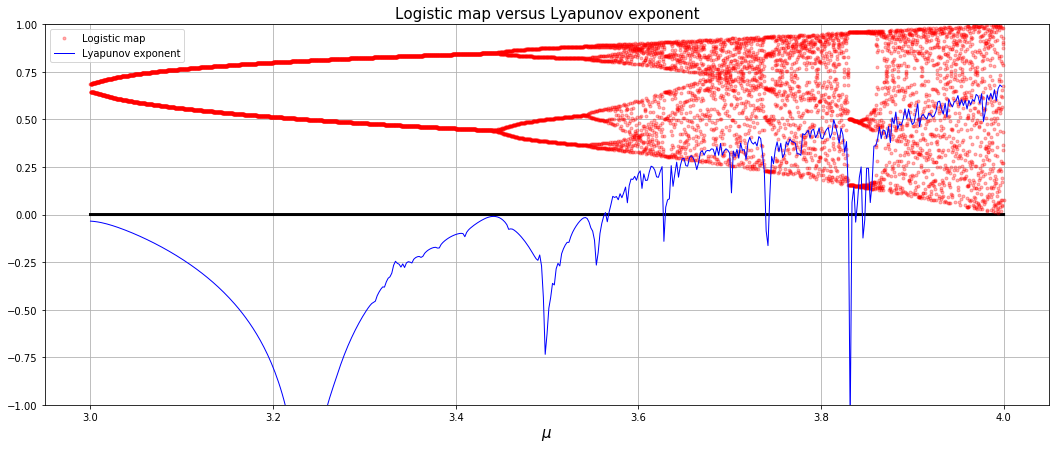

In [156]:
num_points = num_steps
result = []
lambdas = []
maps = []
xmin, xmax = 3, 4
mult = (xmax - xmin) * num_points

mu_values = np.arange(xmin, xmax, 20/num_points)

for r in mu_values:
    x = 0.1
    result = []
    for t in range(100):
        x = r * x * (1 - x)
        result.append(np.log(abs(r - 2*r*x)))
    lambdas.append(np.mean(result))
    # Ignore first 100 iterates.
    for t in range(20):
        x = r * x * (1 - x)
        maps.append(x)

fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(1,1,1)

xticks = np.linspace(xmin, xmax, mult)
zero = [0] * mult
ax1.plot(xticks, zero, 'k-', linewidth=3)
ax1.plot(xticks, maps,'r.', alpha = 0.3, label='Logistic map')
ax1.set_xlabel('r')
ax1.plot(mu_values, lambdas, 'b-', linewidth=1, label='Lyapunov exponent')
ax1.grid('on')
ax1.set_ylim(-1, 1)
ax1.set_xlabel('$\mu$', fontsize=15)
ax1.legend(loc='best')
ax1.set_title('Logistic map versus Lyapunov exponent', fontsize=15)

plt.show()

In [38]:
serie = np.array(serie)

In [65]:
result = np.log(np.abs(serie[:-1]-serie[1:]))

/Users/rodney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [68]:
lambdas = np.take(result, np.array([i*10 for i in range(1000)]))

In [87]:
xticks = np.arange(result[:1000].shape[0])
print(xticks.shape, result.shape, lambdas.shape)

(1000,) (9999,) (1000,)


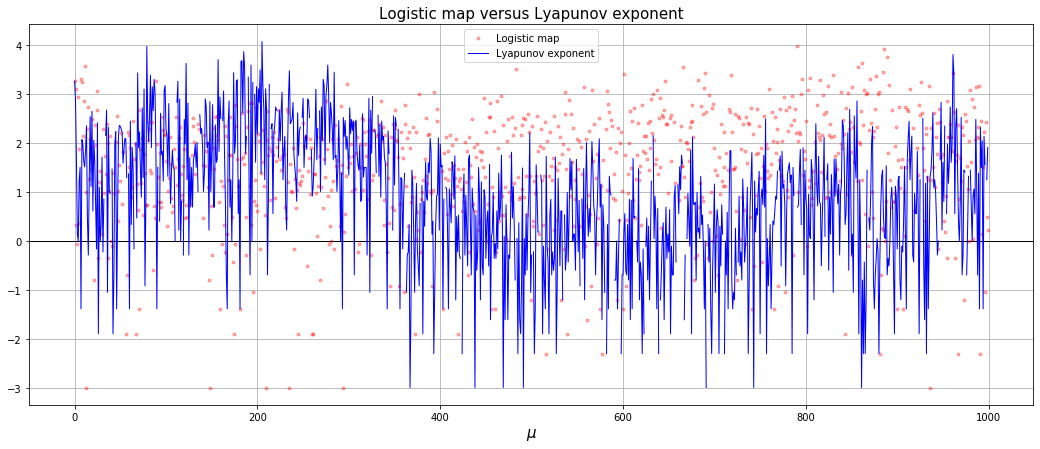

In [91]:
fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(1,1,1)

ax1.axhline(y=0, linewidth=1, color='k')
ax1.plot(xticks, result[:1000],'r.', alpha = 0.3, label='Logistic map')
ax1.set_xlabel('r')
ax1.plot(xticks, lambdas, 'b-', linewidth=1, label='Lyapunov exponent')
ax1.grid('on')
ax1.set_xlabel('$\mu$', fontsize=15)
ax1.legend(loc='best')
plt.show()

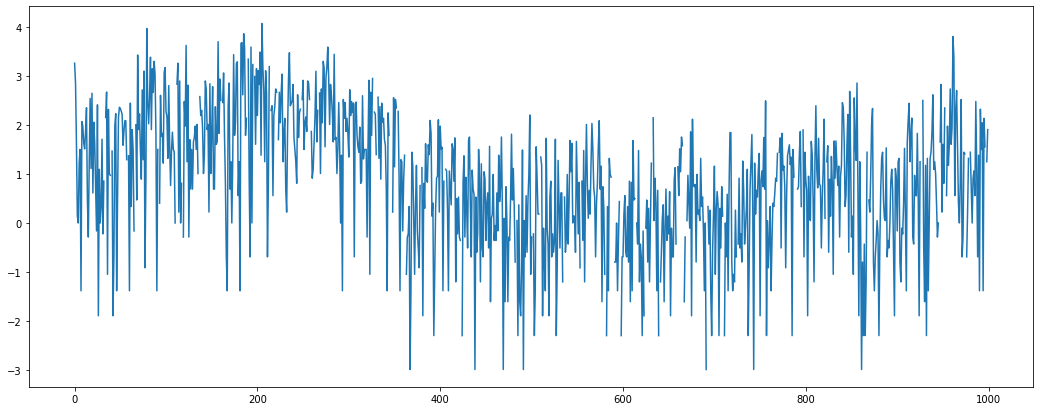

In [63]:
fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(s)
plt.show()

In [129]:
num_points = num_steps
result = []
lambdas = []
maps = []
xmin, xmax = 3, 4
mult = (xmax - xmin) * num_points
mult

10000

In [130]:
mu_values = np.arange(xmin, xmax, 20/num_points)

In [131]:
for r in mu_values:
    x = series[0,0]
    result = []
    for t in range(100):
        x = r * x * (1 - x)
        result.append(np.log(abs(r - 2*r*x)))
    lambdas.append(np.mean(result))
    # Ignore first 100 iterates.
    for t in range(20):
        x = r * x * (1 - x)
        maps.append(x)

/Users/rodney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """


In [152]:
x = series[0,0]
for _ in range(10):
    x = r * x * (1 - x)
    print(x)

-7703986.769654789
-237286976564302.66
-2.251078267696124e+29
-2.025927876243998e+59
-1.6409326271450126e+119
-1.076525422754218e+239
-inf
-inf
-inf
-inf


/Users/rodney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


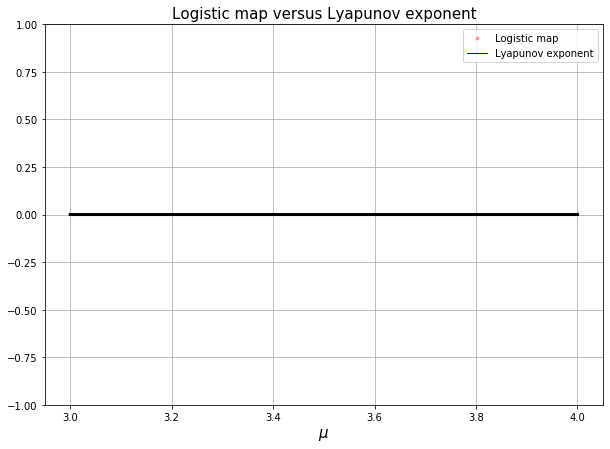

In [132]:
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(1,1,1)

xticks = np.linspace(xmin, xmax, mult)
zero = [0] * mult
ax1.plot(xticks, zero, 'k-', linewidth=3)
ax1.plot(xticks, maps,'r.', alpha = 0.3, label='Logistic map')
ax1.set_xlabel('r')
ax1.plot(mu_values, lambdas, 'b-', linewidth=1, label='Lyapunov exponent')
ax1.grid('on')
ax1.set_ylim(-1, 1)
ax1.set_xlabel('$\mu$', fontsize=15)
ax1.legend(loc='best')
ax1.set_title('Logistic map versus Lyapunov exponent', fontsize=15)

plt.show()